### Moving Average Convergence/Divergence (MACD) Strategy Implementation
Implement MACD and optimize it on all symbols in the avarage ETFs amd Stocks set

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import pickle
import itertools
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover

/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# change into Dataset't directory
os.chdir("../dataset")

In [3]:
with open("3_1_avg_stocks.pckl", "rb") as f:
    %time avg_Stocks = pickle.load(f)

CPU times: user 238 µs, sys: 315 µs, total: 553 µs
Wall time: 500 µs


In [4]:
with open("3_1_avg_etfs.pckl", "rb") as f:
    %time avg_ETFs = pickle.load(f)

CPU times: user 171 µs, sys: 226 µs, total: 397 µs
Wall time: 341 µs


In [5]:
with open("3_1_stock.pckl", "rb") as f:
    %time Stocks = pickle.load(f)

CPU times: user 782 ms, sys: 269 ms, total: 1.05 s
Wall time: 1.05 s


In [6]:
with open("3_1_etfs.pckl", "rb") as f:
    %time ETFs = pickle.load(f)

CPU times: user 16 ms, sys: 131 µs, total: 16.1 ms
Wall time: 15.5 ms


In [7]:
# Get symbol real names
ndt_reference = pd.read_csv("ndt_reference.csv")

In [8]:
avg_ETFs = pd.merge(avg_ETFs, ndt_reference[["Symbol", "Security Name"]], on="Symbol")
avg_Stocks = pd.merge(avg_Stocks, ndt_reference[["Symbol", "Security Name"]], on="Symbol")

In [9]:
# Define function for MACD 
def MACD(series, long=24, short=12, signal=9):
    shortEMA = series.ewm(span=short, adjust=False).mean()
    longEMA = series.ewm(span=long, adjust=False).mean()
    MACD = shortEMA - longEMA
    MACD_signal = MACD.ewm(span=signal, adjust=False).mean()
    return (MACD, MACD_signal)


In [10]:
# Create MACD strategy with backtesting.py
class MACDCrossover(Strategy):
    # set defaults
    long = 31
    short = 12
    signal = 9
    short_sell = False

    def init(self):
        # create MACD and MACD_signal series
        (self.macd, self.macd_signal) = self.I(MACD, pd.Series(self.data["Adj Close"]), long=self.long, short=self.short, signal=self.signal)

    def next(self):
        price = self.data["Close"][-1]
        # Define a simple trading strategy
        if crossover(self.macd_signal, self.macd):
            if self.short_sell:
                self.sell()
            else:
                self.position.close()
        elif crossover(self.macd, self.macd_signal):
            # self.buy(tp=1.2*price, sl=0.97*price)
            self.buy()

### Run MACD on the ETFs

In [11]:
ETF_symbols = list(avg_ETFs["Symbol"])

#### Run backtest with default parameters

In [12]:
etf_bt_stats = {}
for symbol in ETF_symbols:
    bt = Backtest(ETFs[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats = bt.run()
    etf_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


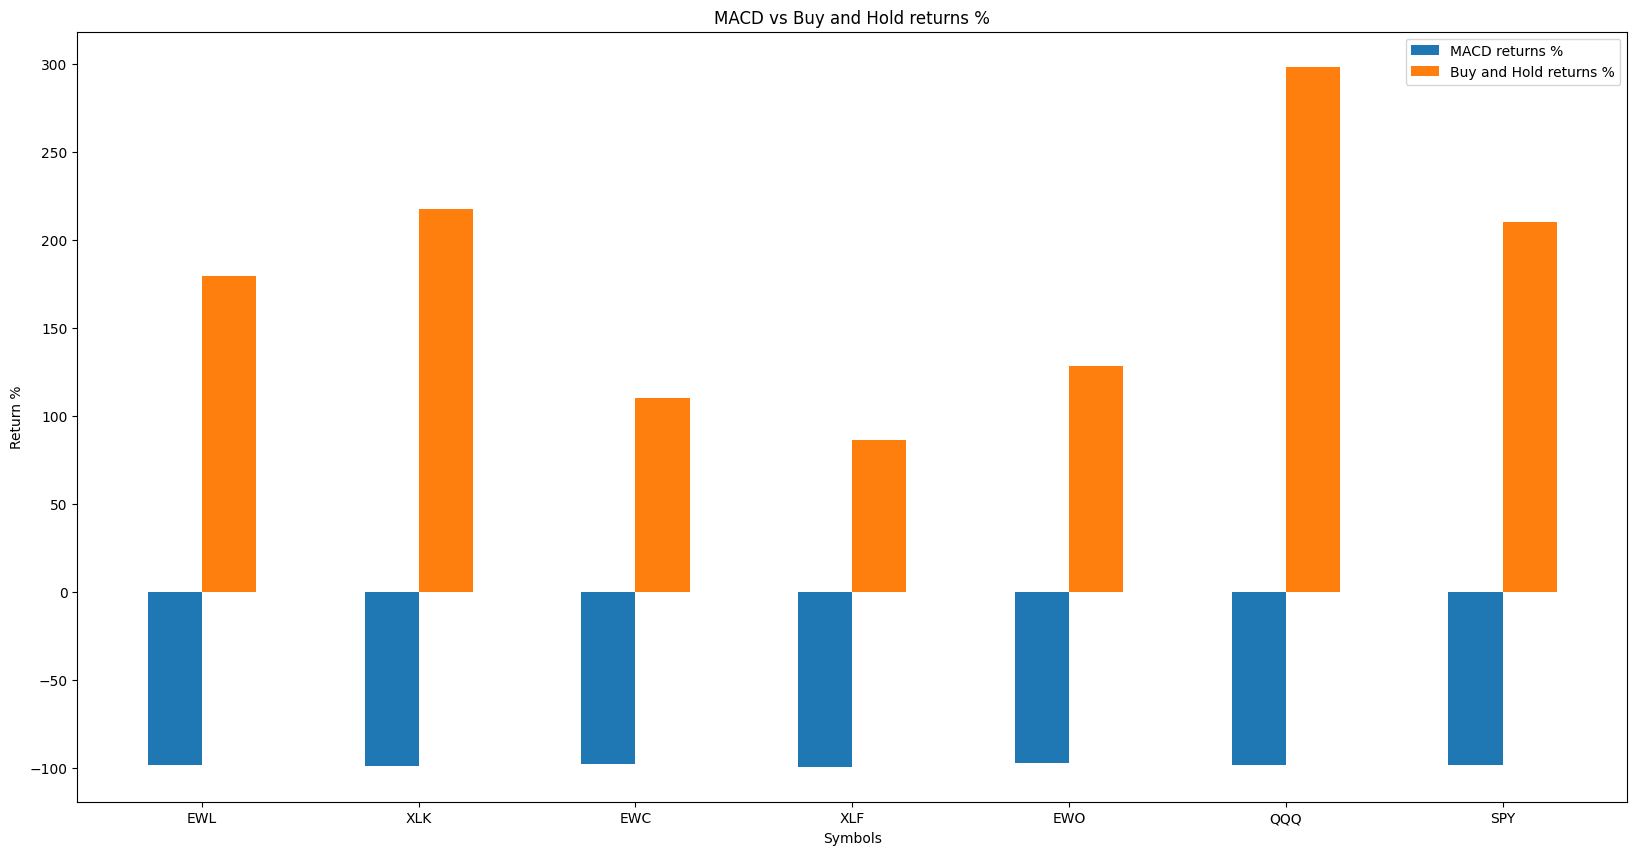

In [13]:
# Plot MACD results
symbols = list(etf_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in etf_bt_stats.keys():
    stats = etf_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD vs Buy and Hold returns %")
plt.legend()
plt.show()

In [14]:
for symbol in etf_bt_stats.keys():
    stats = etf_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

EWL
 MACDCrossover
 Return [%] -98.44919680603029 Buy & Hold Return [%] 179.42205508852186

XLK
 MACDCrossover
 Return [%] -98.98498429967884 Buy & Hold Return [%] 217.83539472061727

EWC
 MACDCrossover
 Return [%] -97.88843586021429 Buy & Hold Return [%] 110.10526499353854

XLF
 MACDCrossover
 Return [%] -99.25493713322659 Buy & Hold Return [%] 86.68148413193785

EWO
 MACDCrossover
 Return [%] -96.93459817108169 Buy & Hold Return [%] 128.39437135508362

QQQ
 MACDCrossover
 Return [%] -98.50742363651275 Buy & Hold Return [%] 298.51186948590043

SPY
 MACDCrossover
 Return [%] -98.25684076385511 Buy & Hold Return [%] 210.22948169585308



#### Run backtest with optimisation

In [15]:
# .loc["2000-01-03":]
etf_bt_stats = {}
for symbol in ETF_symbols:
    bt = Backtest(ETFs[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats, heatmap = bt.optimize(
        #long = range(31, 252, 2),
        #short = range(12, 63, 2),
        #signal = range(9, 63, 2),
        long = range(31, 252, 5),
        short = range(12, 63, 5),
        signal = range(9, 63, 5),
        short_sell = [0, 1],
        maximize="Equity Final [$]",
        return_heatmap=True
        )
    etf_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        "heatmap": heatmap
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.
  output = _optimize_grid()
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.       
  output = _optimize_grid()
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.       
  output = _optimize_grid()
Backtest.optimize:   0%|                                                                                                                              | 0/37 [00:00<?, ?it/s]/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bo

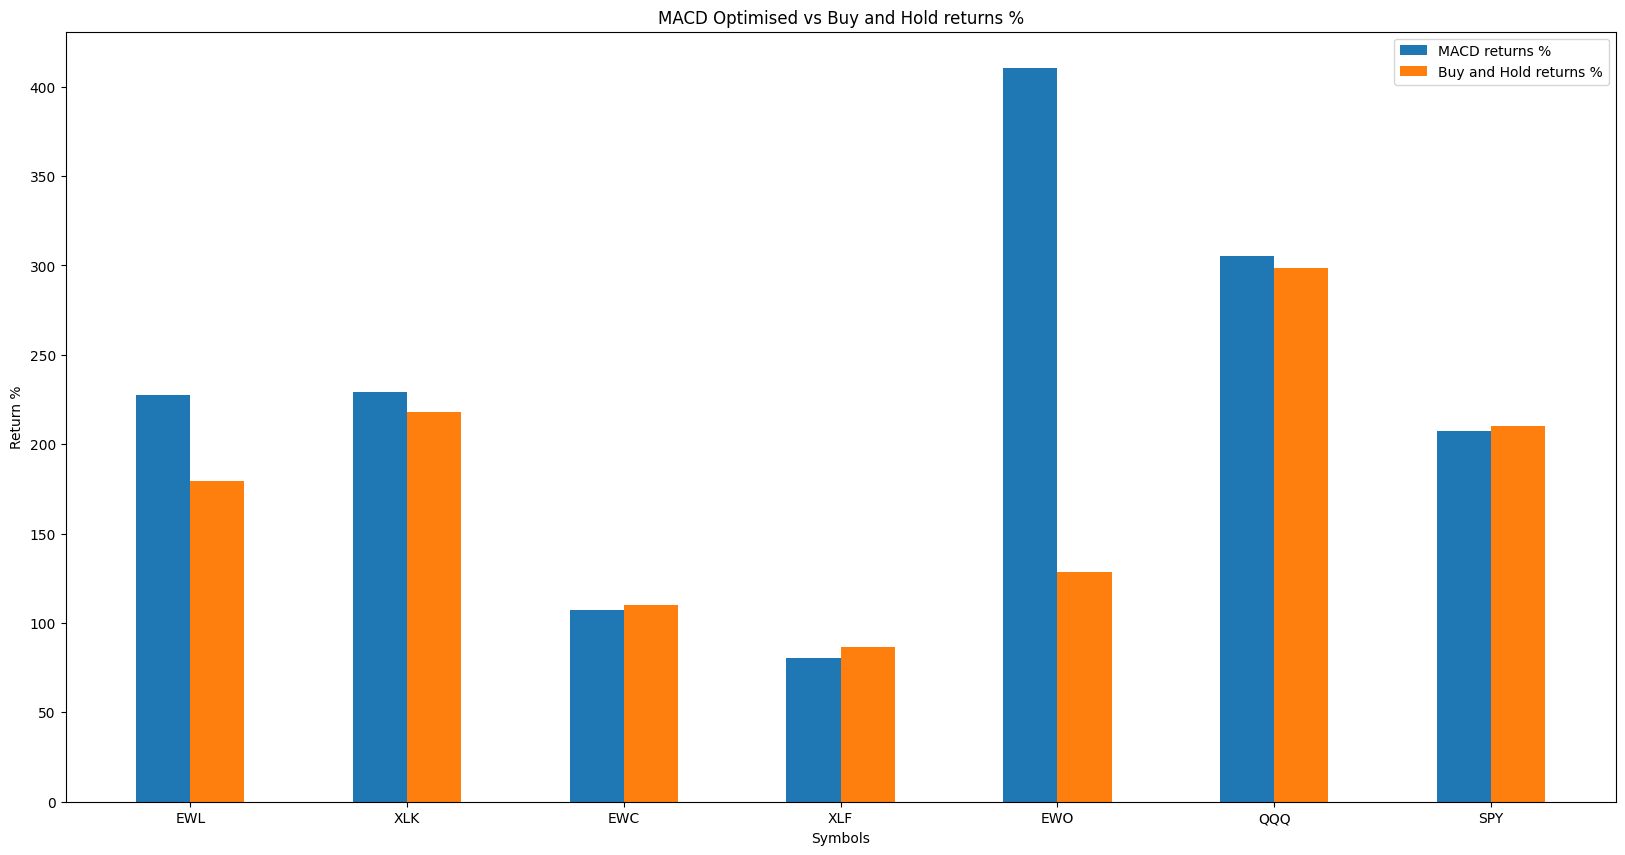

In [16]:
# Plot MACD results
symbols = list(etf_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in etf_bt_stats.keys():
    stats = etf_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD Optimised vs Buy and Hold returns %")
plt.legend()
plt.show()

In [17]:
for symbol in etf_bt_stats.keys():
    stats = etf_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

EWL
 MACDCrossover(long=36,short=22,signal=34,short_sell=1)
 Return [%] 227.72176364681243 Buy & Hold Return [%] 179.42205508852186

XLK
 MACDCrossover(long=31,short=17,signal=14,short_sell=1)
 Return [%] 228.95252540222165 Buy & Hold Return [%] 217.83539472061727

EWC
 MACDCrossover(long=146,short=27,signal=9,short_sell=1)
 Return [%] 107.25994234558105 Buy & Hold Return [%] 110.10526499353854

XLF
 MACDCrossover(long=71,short=62,signal=59,short_sell=1)
 Return [%] 80.39343387285236 Buy & Hold Return [%] 86.68148413193785

EWO
 MACDCrossover(long=166,short=62,signal=49,short_sell=0)
 Return [%] 410.222021632843 Buy & Hold Return [%] 128.39437135508362

QQQ
 MACDCrossover(long=36,short=12,signal=9,short_sell=1)
 Return [%] 305.13964974975585 Buy & Hold Return [%] 298.51186948590043

SPY
 MACDCrossover(long=31,short=12,signal=9,short_sell=1)
 Return [%] 207.25401535400388 Buy & Hold Return [%] 210.22948169585308



### Run MACD on the Stocks

In [18]:
Stock_symbols = list(avg_Stocks["Symbol"])

#### Run backtest with default parameters

In [19]:
stock_bt_stats = {}
for symbol in Stock_symbols:
    bt = Backtest(Stocks[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats = bt.run()
    stock_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


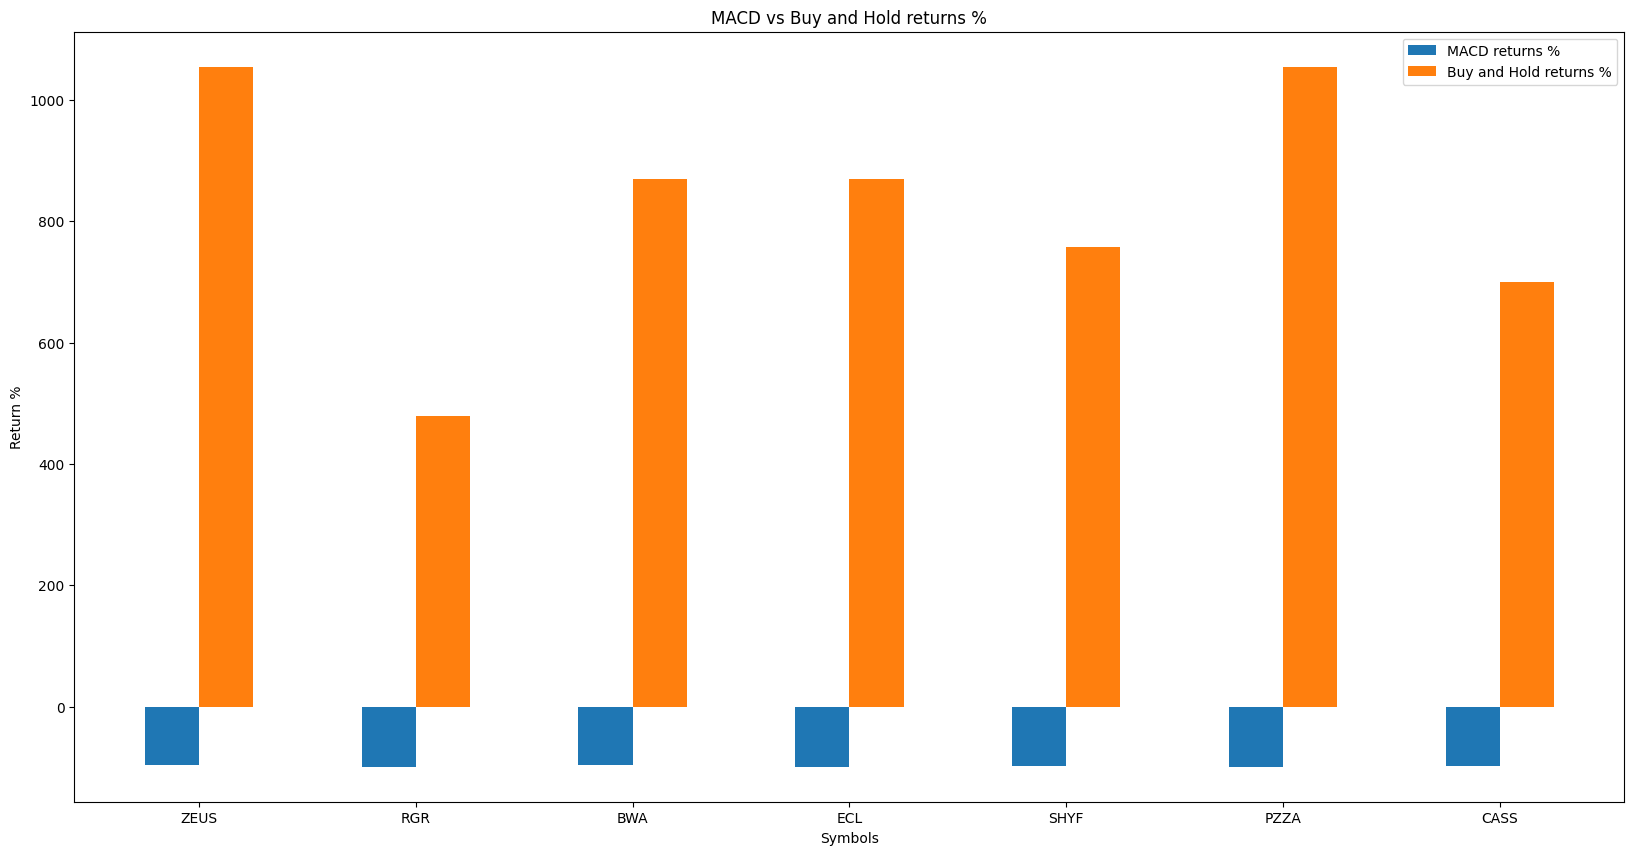

In [20]:
# Plot MACD results
symbols = list(stock_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD vs Buy and Hold returns %")
plt.legend()
plt.show()

In [21]:
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

ZEUS
 MACDCrossover
 Return [%] -96.70439065071116 Buy & Hold Return [%] 1054.9091289569806

RGR
 MACDCrossover
 Return [%] -98.97848049416548 Buy & Hold Return [%] 479.3566296984267

BWA
 MACDCrossover
 Return [%] -96.71922138119723 Buy & Hold Return [%] 869.9348387782582

ECL
 MACDCrossover
 Return [%] -98.92166444984434 Buy & Hold Return [%] 869.5522226109038

SHYF
 MACDCrossover
 Return [%] -97.26235523212448 Buy & Hold Return [%] 757.6933011787811

PZZA
 MACDCrossover
 Return [%] -99.14073104592327 Buy & Hold Return [%] 1053.644882629965

CASS
 MACDCrossover
 Return [%] -98.21441769619965 Buy & Hold Return [%] 699.6538482642471



#### Run backtest with optimisation

In [22]:
# .loc["2000-01-03":]
stock_bt_stats = {}
for symbol in Stock_symbols:
    bt = Backtest(Stocks[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats, heatmap = bt.optimize(
        #long = range(31, 252, 2),
        #short = range(12, 63, 2),
        #signal = range(9, 63, 2),
        long = range(31, 252, 5),
        short = range(12, 63, 5),
        signal = range(9, 63, 5),
        short_sell = [0, 1],
        maximize="Equity Final [$]",
        return_heatmap=True
        )
    stock_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        "heatmap": heatmap
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.
  output = _optimize_grid()
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.       
  output = _optimize_grid()
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.       
  output = _optimize_grid()
Backtest.optimize:   0%|                                                                                                                              | 0/37 [00:00<?, ?it/s]/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bo

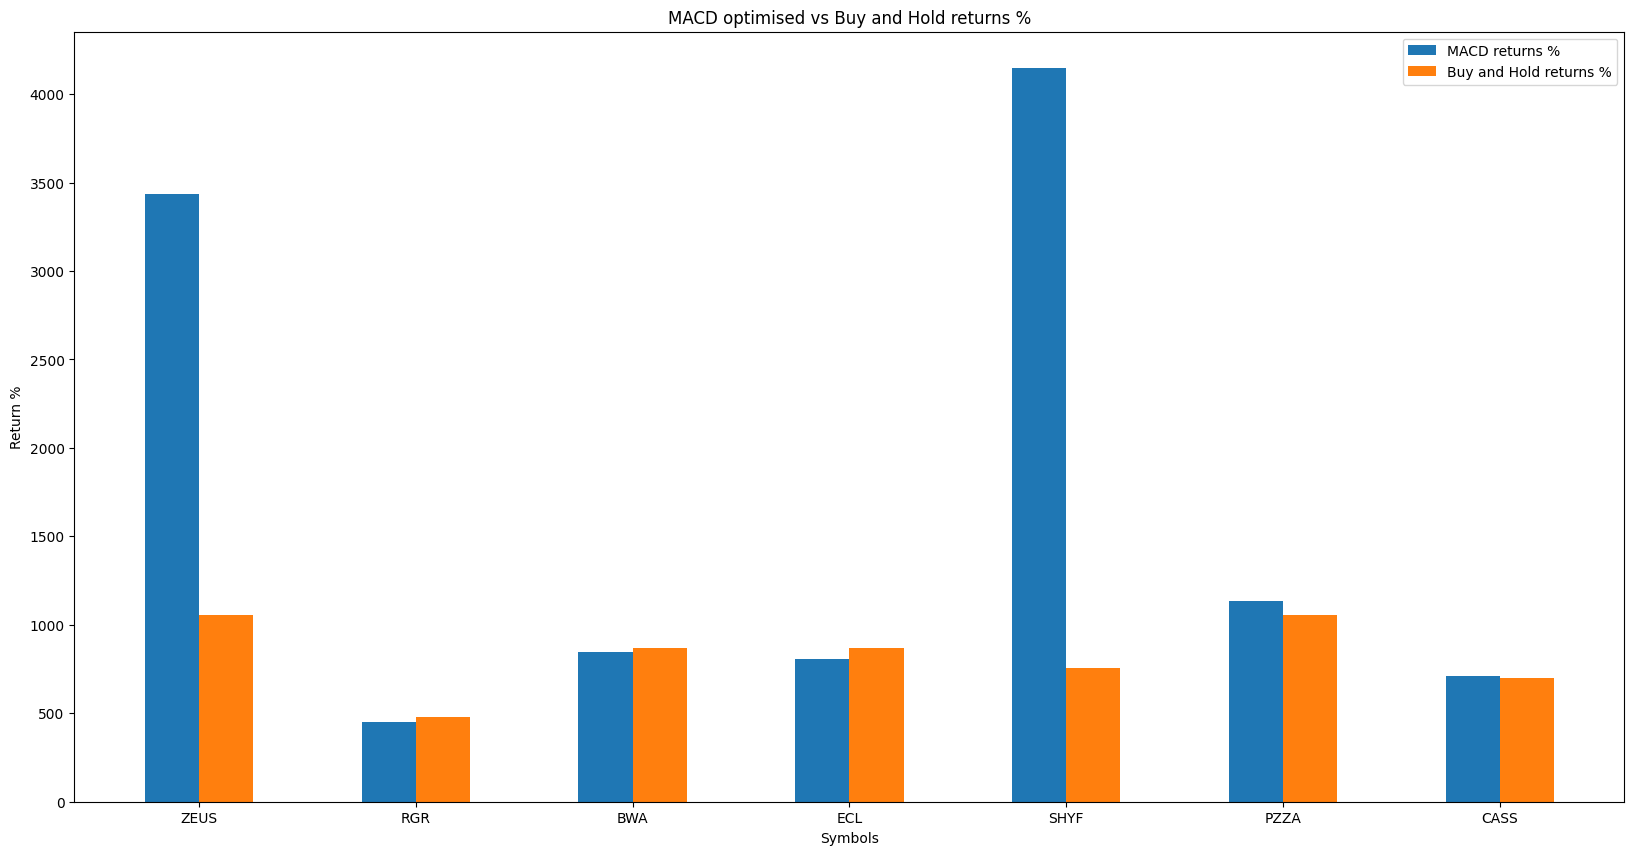

In [23]:
# Plot MACD results
symbols = list(stock_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD optimised vs Buy and Hold returns %")
plt.legend()
plt.show()

In [24]:
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

ZEUS
 MACDCrossover(long=121,short=47,signal=34,short_sell=0)
 Return [%] 3435.0409527923994 Buy & Hold Return [%] 1054.9091289569806

RGR
 MACDCrossover(long=51,short=47,signal=9,short_sell=1)
 Return [%] 450.4108795391845 Buy & Hold Return [%] 479.3566296984267

BWA
 MACDCrossover(long=31,short=57,signal=9,short_sell=1)
 Return [%] 845.9767007886029 Buy & Hold Return [%] 869.9348387782582

ECL
 MACDCrossover(long=31,short=12,signal=9,short_sell=1)
 Return [%] 807.9739561309816 Buy & Hold Return [%] 869.5522226109038

SHYF
 MACDCrossover(long=36,short=47,signal=39,short_sell=1)
 Return [%] 4145.4087066824595 Buy & Hold Return [%] 757.6933011787811

PZZA
 MACDCrossover(long=31,short=17,signal=44,short_sell=1)
 Return [%] 1137.4209308239745 Buy & Hold Return [%] 1053.644882629965

CASS
 MACDCrossover(long=31,short=12,signal=9,short_sell=1)
 Return [%] 710.4712073558617 Buy & Hold Return [%] 699.6538482642471



### Run MACD on the hand picked Stocks

In [25]:
Stock_symbols = []
[Stock_symbols.append(item) for item in ["KO", "AAPL", "SHEL", "IBM"]]

[None, None, None, None]

#### Run backtest with default parameters

In [26]:
stock_bt_stats = {}
for symbol in Stock_symbols:
    bt = Backtest(Stocks[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats = bt.run()
    stock_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


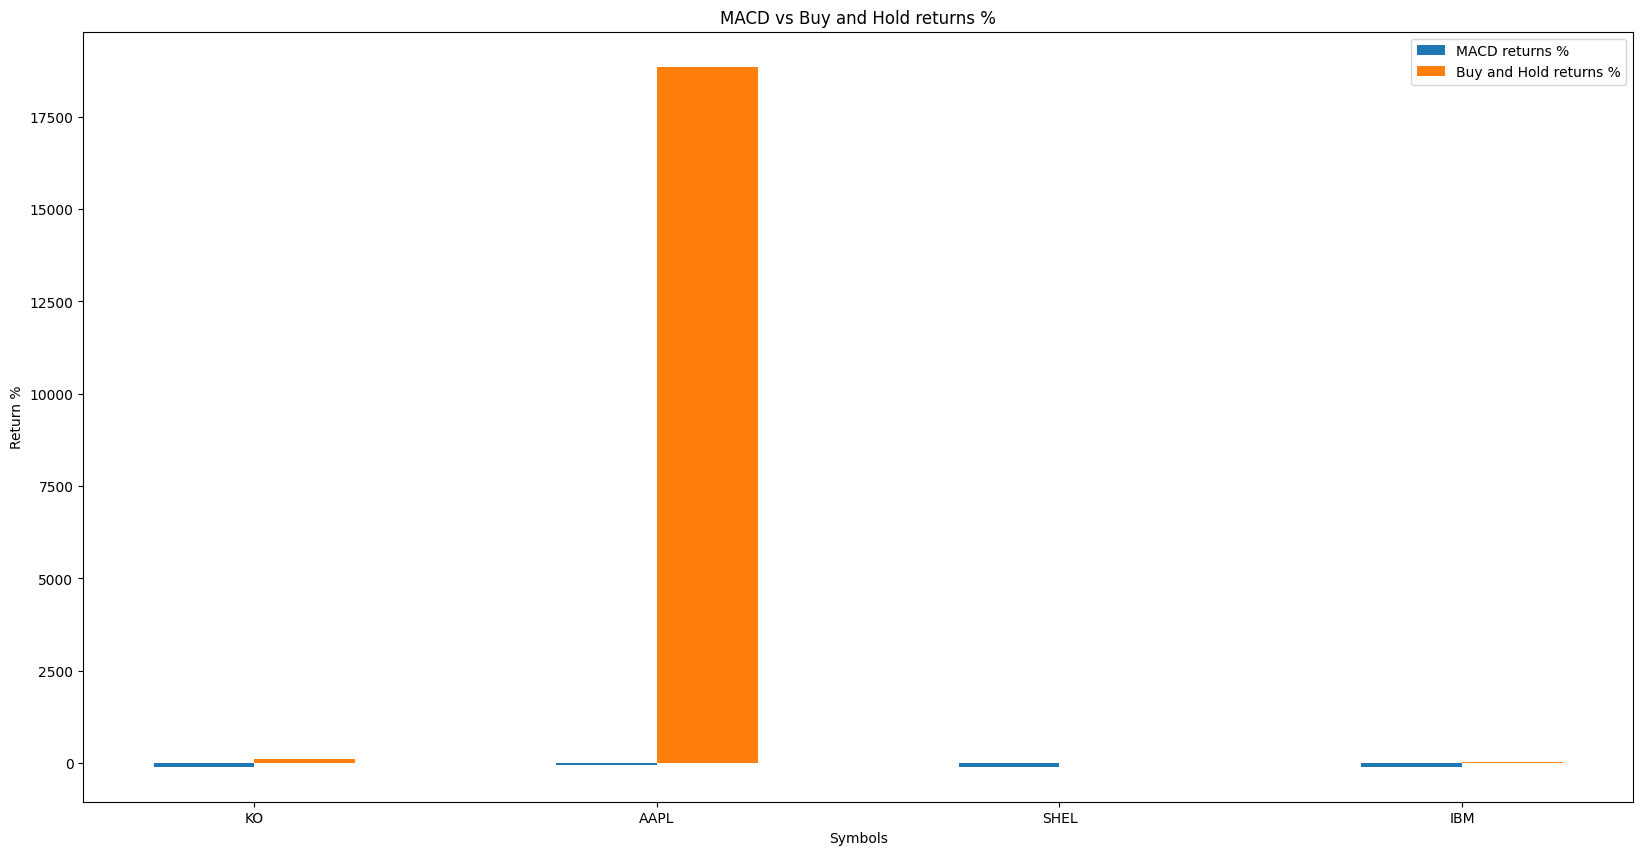

In [27]:
# Plot MACD results
symbols = list(stock_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD vs Buy and Hold returns %")
plt.legend()
plt.show()

In [28]:
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

KO
 MACDCrossover
 Return [%] -99.2038988316346 Buy & Hold Return [%] 110.41242172342712

AAPL
 MACDCrossover
 Return [%] -49.84089503425804 Buy & Hold Return [%] 18856.578796547252

SHEL
 MACDCrossover
 Return [%] -98.43000906158454 Buy & Hold Return [%] 5.852629009046041

IBM
 MACDCrossover
 Return [%] -94.6617861894228 Buy & Hold Return [%] 33.4010745537077



#### Run backtest with optimisation

In [29]:
# .loc["2000-01-03":]
stock_bt_stats = {}
for symbol in Stock_symbols:
    bt = Backtest(Stocks[symbol], MACDCrossover, cash=100000, commission=0.02)
    stats, heatmap = bt.optimize(
        #long = range(31, 252, 2),
        #short = range(12, 63, 2),
        #signal = range(9, 63, 2),
        long = range(31, 252, 5),
        short = range(12, 63, 5),
        signal = range(9, 63, 5),
        short_sell = [0, 1],
        maximize="Equity Final [$]",
        return_heatmap=True
        )
    stock_bt_stats[symbol] = {
        "bt": bt,
        "stats": stats,
        "heatmap": heatmap
        }
    # print("{} {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol, stats._strategy, stats["Return [%]"], stats["Buy & Hold Return [%]"]))


/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 10890 configurations.
  output = _optimize_grid()
Backtest.optimize:  43%|██████████████████████████████████████████████████▌                                                                  | 16/37 [00:32<00:13,  1.60it/s]/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_stats.py:114: RuntimeWarning: overflow encountered in scalar power
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + 

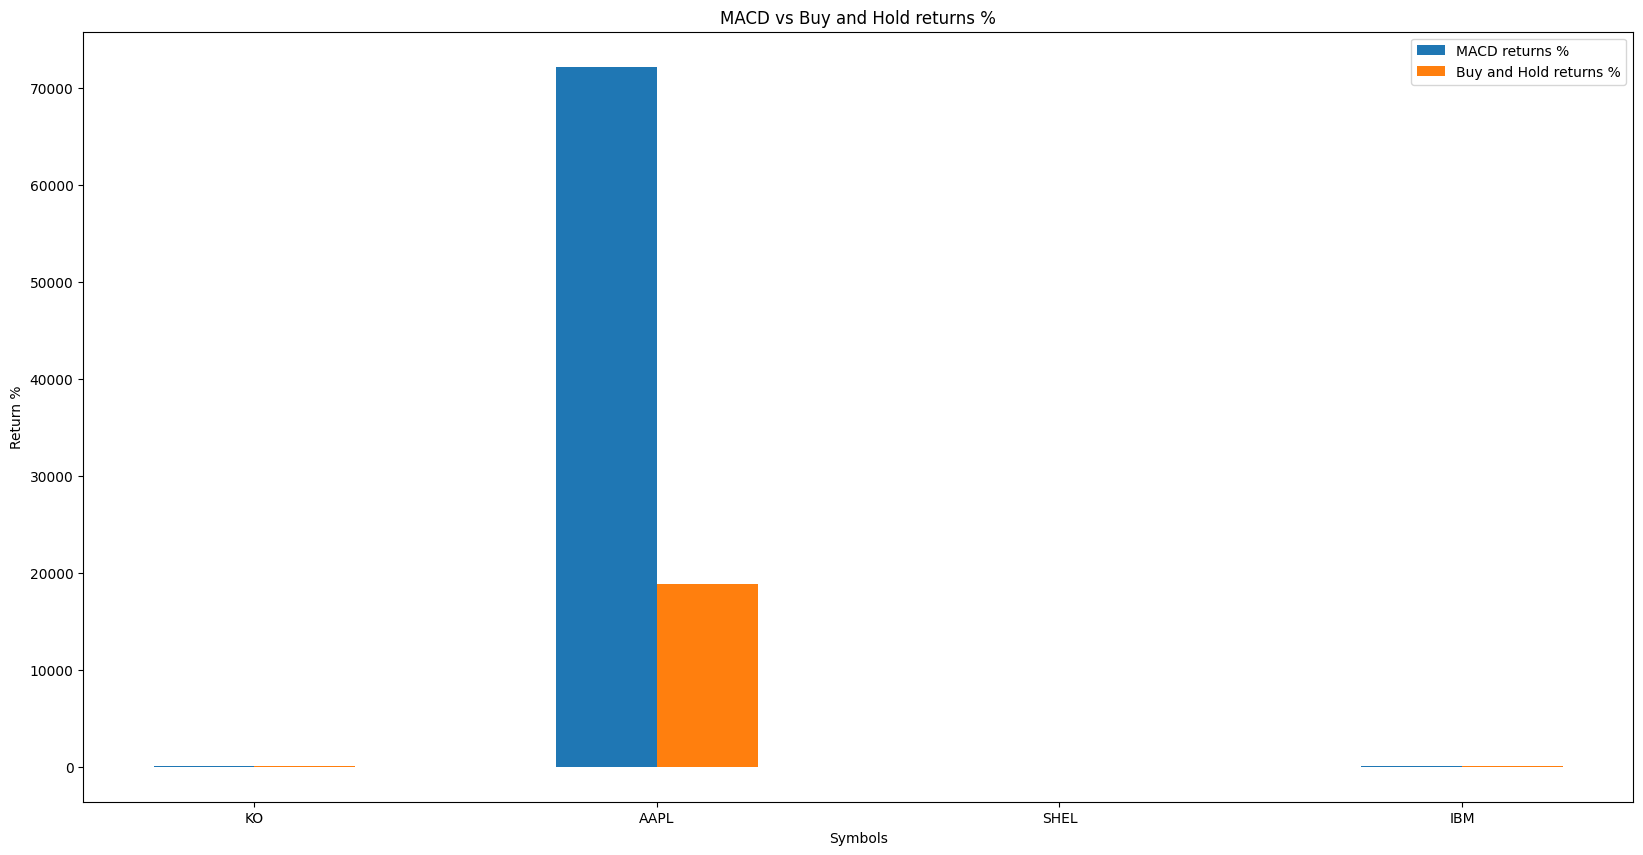

In [30]:
# Plot MACD results
symbols = list(stock_bt_stats.keys())
macd_ret = []
buy_n_hold_ret = []
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    macd_ret.append(stats["Return [%]"])
    buy_n_hold_ret.append(stats["Buy & Hold Return [%]"])

n = len(symbols)
r = np.arange(n)
w = 0.25

plt.figure(figsize=(20,10))

plt.bar(r, macd_ret, width = w, label = "MACD returns %")
plt.bar(r + w, buy_n_hold_ret, width = w, label = "Buy and Hold returns %")
plt.xticks(r + w/2, symbols)

plt.xlabel("Symbols")
plt.ylabel("Return %")
plt.title("MACD vs Buy and Hold returns %")
plt.legend()
plt.show()

In [31]:
for symbol in stock_bt_stats.keys():
    stats = stock_bt_stats[symbol]["stats"]
    print("{}\n {}\n Return [%] {} Buy & Hold Return [%] {}\n".format(symbol,
                                                                      stats._strategy,
                                                                      stats["Return [%]"],
                                                                      stats["Buy & Hold Return [%]"]))

KO
 MACDCrossover(long=51,short=57,signal=59,short_sell=1)
 Return [%] 117.33921749999996 Buy & Hold Return [%] 110.41242172342712

AAPL
 MACDCrossover(long=56,short=57,signal=54,short_sell=1)
 Return [%] 72230.98811943972 Buy & Hold Return [%] 18856.578796547252

SHEL
 MACDCrossover(long=41,short=27,signal=24,short_sell=1)
 Return [%] -2.00282881553653 Buy & Hold Return [%] 5.852629009046041

IBM
 MACDCrossover(long=41,short=12,signal=9,short_sell=1)
 Return [%] 28.118922937927245 Buy & Hold Return [%] 33.4010745537077

